In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
from imblearn.over_sampling import SMOTENC

In [2]:
df = pd.read_excel('/home/sam/tirocinio/DB PAROTIDE DEF_corretto.xlsx', sheet_name='Sheet7')
df = df.loc[df['ESCLUDERE'] == 0]
df.reset_index(inplace = True)
df = df.loc[df['COD ISTO'] != 6]
df.reset_index(inplace = True)
df = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2','COD ISTO']]
df['ADC'] = df['ADC'].apply(lambda s: str(s).replace(',', '.')).astype(float)

In [3]:
y = df['COD ISTO'].copy()
X_not_encoded = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2']].copy()
X = pd.get_dummies(X_not_encoded, columns = ['TIC type'])

In [4]:
y.value_counts()

3    53
4    27
1    12
5     6
2     5
Name: COD ISTO, dtype: int64

In [5]:
seed = 42

In [6]:
#separo test set e training set
#eseguo questa unica separazione iniziale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                   random_state=seed, shuffle = True,
                                                   stratify = y)

## maligni contro benigni

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

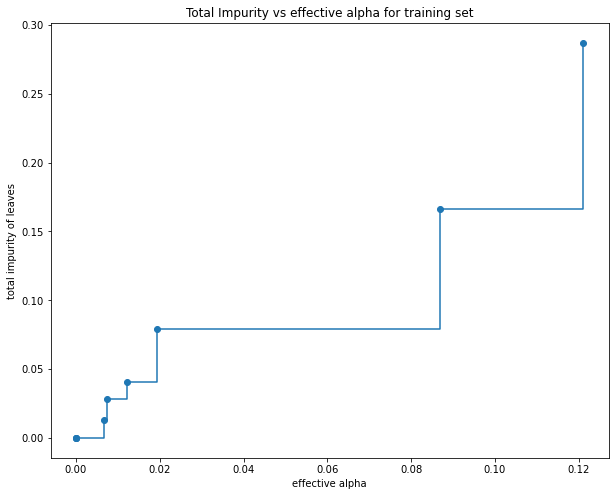

In [7]:


#creazione delle labels
y_train_MvsB= [1 if x in (1,2) else 0 for x in y_train]
y_test_MvsB = [1 if x in (1,2) else 0 for x in y_test]

clf = tree.DecisionTreeClassifier(random_state=seed, class_weight = 'balanced')
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_train_MvsB)

#separo gli alpha dai valori delle impurità nelle foglie
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#desidero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
#rimuovo l'ultimo effective alpha perchè determina un pruning che porta ad avere un DT con un solo nodo
#non includo l'ultimo punto perchè è funzionalmente inutile
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [8]:
#ora alleno vari alberi usando gli effective alpha appena trovati, incluso l'ultimo, e stampo 
#l'ultimo effective alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha, class_weight = 'balanced')
    clf.fit(X_train, y_train_MvsB)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.21291586167780346


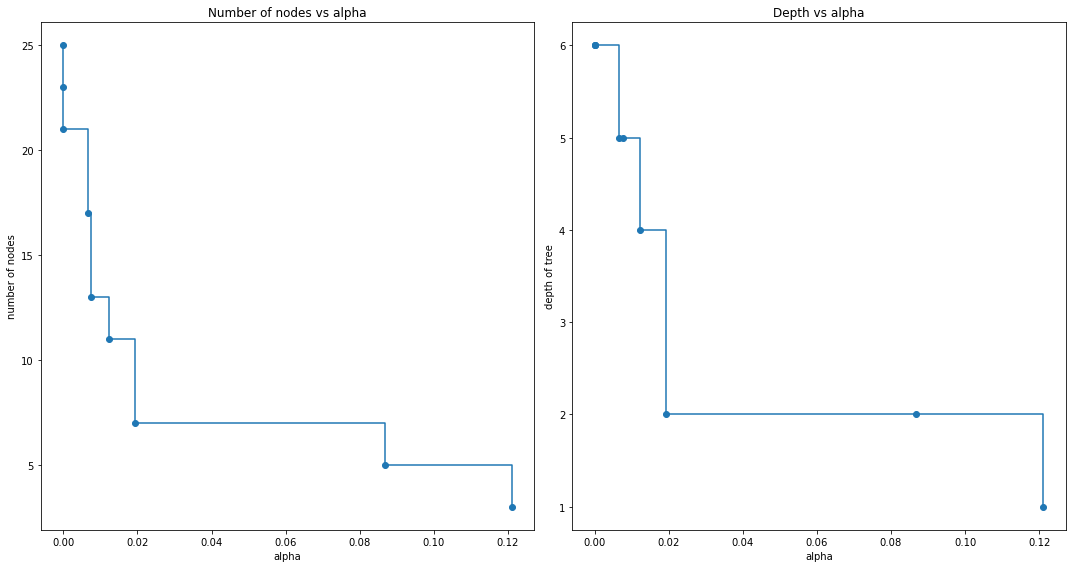

In [9]:
#ora rimuovo l'ultimo valore effective alpha perchè, come ho appena mostrato, conduce ad un albero costituito 
#da un solo nodo
#e mostro come il numero di nodi e la profondità variano al variare dei valori di alpha
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 8)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

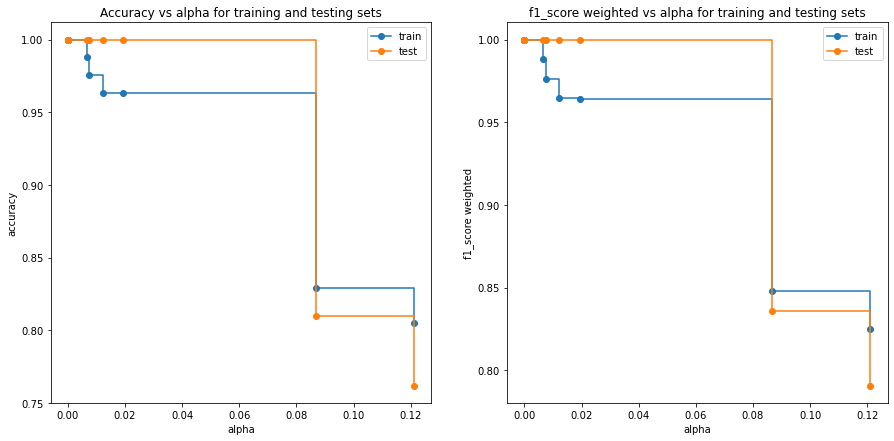

In [10]:
#ora studio come le performance variano al variare di alpha
#in questa cella uso mean accuracy e f1_score weighted
train_scores_acc = [clf.score(X_train, y_train_MvsB) for clf in clfs]
test_scores_acc = [clf.score(X_test, y_test_MvsB) for clf in clfs]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 7)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy vs alpha for training and testing sets")
ax[0].plot(ccp_alphas, train_scores_acc, marker='o', label="train",
        drawstyle="steps-post")
ax[0].plot(ccp_alphas, test_scores_acc, marker='o', label="test",
        drawstyle="steps-post")
ax[0].legend()

train_scores_f1 = [f1_score(y_train_MvsB, clf.predict(X_train), average = 'weighted') for clf in clfs]
test_scores_f1 =[f1_score(y_test_MvsB, clf.predict(X_test), average = 'weighted') for clf in clfs]
                 

ax[1].set_xlabel("alpha")
ax[1].set_ylabel("f1_score weighted")
ax[1].set_title("f1_score weighted vs alpha for training and testing sets")
ax[1].plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax[1].legend()

plt.show()



[Text(372.0, 747.4499999999999, 'TIC type_C <= 0.5\ngini = 0.5\nsamples = 82\nvalue = [41.0, 41.0]\nclass = 1'),
 Text(186.0, 611.55, 'ADC <= 0.6\ngini = 0.258\nsamples = 56\nvalue = [32.559, 5.857]\nclass = 0'),
 Text(93.0, 475.65, 'gini = 0.0\nsamples = 2\nvalue = [0.0, 5.857]\nclass = 1'),
 Text(279.0, 475.65, 'gini = -0.0\nsamples = 54\nvalue = [32.559, 0.0]\nclass = 0'),
 Text(558.0, 611.55, 'ADC <= 0.975\ngini = 0.312\nsamples = 26\nvalue = [8.441, 35.143]\nclass = 1'),
 Text(465.0, 475.65, 'gini = 0.07\nsamples = 13\nvalue = [1.206, 32.214]\nclass = 1'),
 Text(651.0, 475.65, 'ADC <= 1.275\ngini = 0.41\nsamples = 13\nvalue = [7.235, 2.929]\nclass = 0'),
 Text(558.0, 339.74999999999994, 'T2 <= 0.5\ngini = 0.495\nsamples = 5\nvalue = [2.412, 2.929]\nclass = 1'),
 Text(465.0, 203.8499999999999, 'gini = 0.0\nsamples = 3\nvalue = [1.809, 0.0]\nclass = 0'),
 Text(651.0, 203.8499999999999, 'ADC <= 1.225\ngini = 0.283\nsamples = 2\nvalue = [0.603, 2.929]\nclass = 1'),
 Text(558.0, 67.949

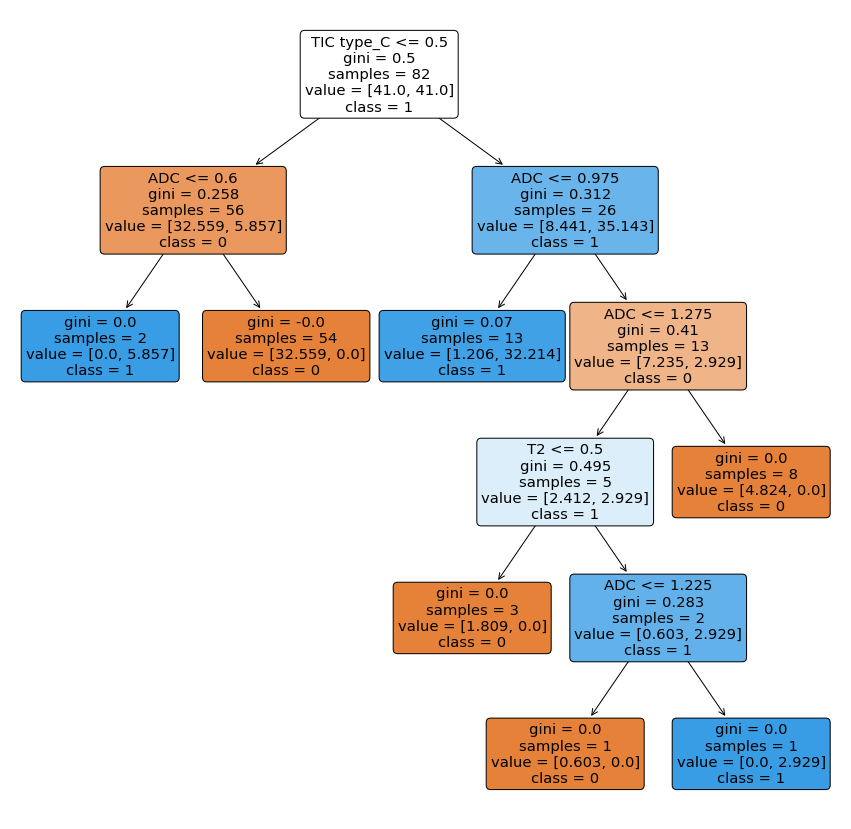

In [11]:
best_clf = clfs[4]
plt.figure(figsize=(15,15))
tree.plot_tree(best_clf,
               feature_names = X.columns,
               class_names = ['0', '1'], filled = True, rounded = True)

## 1 vs all

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

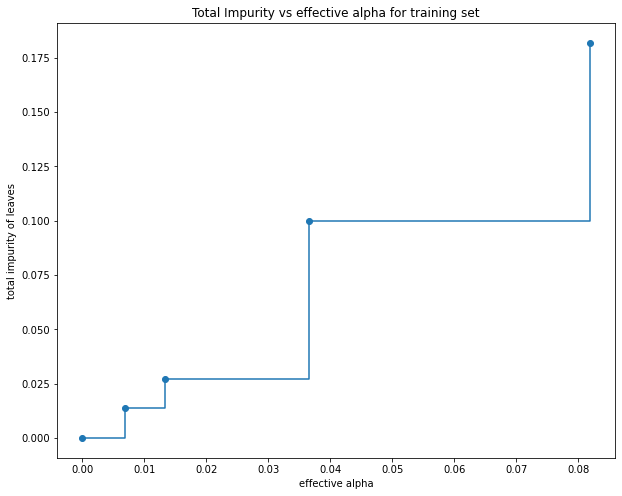

In [12]:
#creazione delle labels
y_train_1vsAll= [1 if x == 1 else 0 for x in y_train]
y_test_1vsAll = [1 if x == 1 else 0 for x in y_test]

clf = tree.DecisionTreeClassifier(random_state=seed, class_weight = 'balanced')
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_train_1vsAll)

#separo gli alpha dai valori delle impurità nelle foglie
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#desidero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
#rimuovo l'ultimo effective alpha perchè determina un pruning che porta ad avere un DT con un solo nodo
#non includo l'ultimo punto perchè è funzionalmente inutile
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [13]:
#ora alleno vari alberi usando gli effective alpha appena trovati, incluso l'ultimo, e stampo 
#l'ultimo effective alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha, class_weight = 'balanced')
    clf.fit(X_train, y_train_1vsAll)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3181818181818186


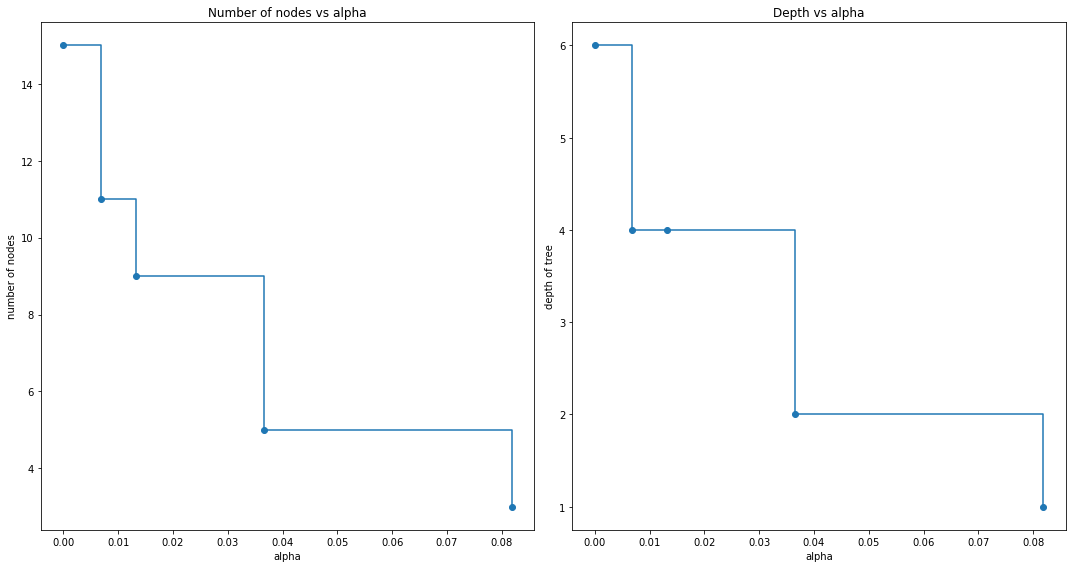

In [14]:
#ora rimuovo l'ultimo valore effective alpha perchè, come ho appena mostrato, conduce ad un albero costituito 
#da un solo nodo
#e mostro come il numero di nodi e la profondità variano al variare dei valori di alpha
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 8)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

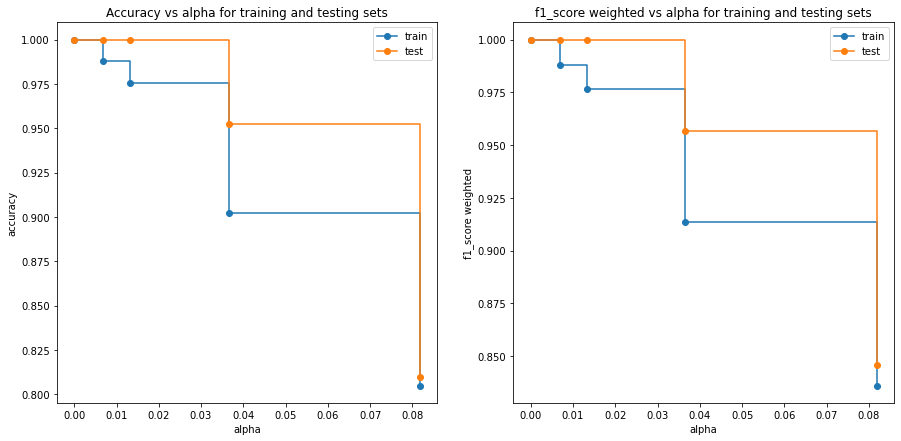

In [15]:
#ora studio come le performance variano al variare di alpha
#in questa cella uso mean accuracy e f1_score weighted
train_scores_acc = [clf.score(X_train, y_train_1vsAll) for clf in clfs]
test_scores_acc = [clf.score(X_test, y_test_1vsAll) for clf in clfs]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 7)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy vs alpha for training and testing sets")
ax[0].plot(ccp_alphas, train_scores_acc, marker='o', label="train",
        drawstyle="steps-post")
ax[0].plot(ccp_alphas, test_scores_acc, marker='o', label="test",
        drawstyle="steps-post")
ax[0].legend()

train_scores_f1 = [f1_score(y_train_1vsAll, clf.predict(X_train), average = 'weighted') for clf in clfs]
test_scores_f1 =[f1_score(y_test_1vsAll, clf.predict(X_test), average = 'weighted') for clf in clfs]
                 

ax[1].set_xlabel("alpha")
ax[1].set_ylabel("f1_score weighted")
ax[1].set_title("f1_score weighted vs alpha for training and testing sets")
ax[1].plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax[1].legend()

plt.show()



[Text(418.5, 733.86, 'TIC type_C <= 0.5\ngini = 0.5\nsamples = 82\nvalue = [41.0, 41.0]\nclass = 1'),
 Text(279.0, 570.78, 'gini = -0.0\nsamples = 56\nvalue = [31.889, 0.0]\nclass = 0'),
 Text(558.0, 570.78, 'ADC <= 1.275\ngini = 0.298\nsamples = 26\nvalue = [9.111, 41.0]\nclass = 1'),
 Text(418.5, 407.70000000000005, 'T2 <= 0.5\ngini = 0.18\nsamples = 18\nvalue = [4.556, 41.0]\nclass = 1'),
 Text(279.0, 244.62, 'Segni macro malignità <= 0.5\ngini = 0.496\nsamples = 7\nvalue = [3.417, 4.1]\nclass = 1'),
 Text(139.5, 81.54000000000008, 'gini = 0.0\nsamples = 6\nvalue = [3.417, 0.0]\nclass = 0'),
 Text(418.5, 81.54000000000008, 'gini = 0.0\nsamples = 1\nvalue = [0.0, 4.1]\nclass = 1'),
 Text(558.0, 244.62, 'gini = 0.058\nsamples = 11\nvalue = [1.139, 36.9]\nclass = 1'),
 Text(697.5, 407.70000000000005, 'gini = -0.0\nsamples = 8\nvalue = [4.556, 0.0]\nclass = 0')]

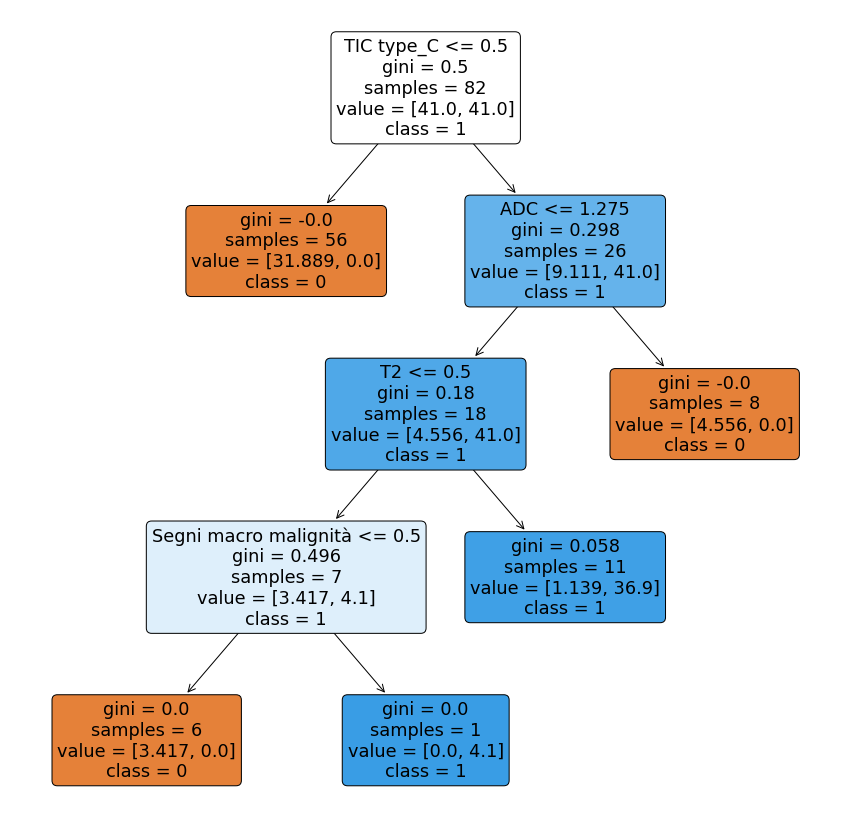

In [16]:
best_clf = clfs[2]
plt.figure(figsize=(15,15))
tree.plot_tree(best_clf,
               feature_names = X.columns,
               class_names = ['0', '1'], filled = True, rounded = True)

## 2 vs All

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

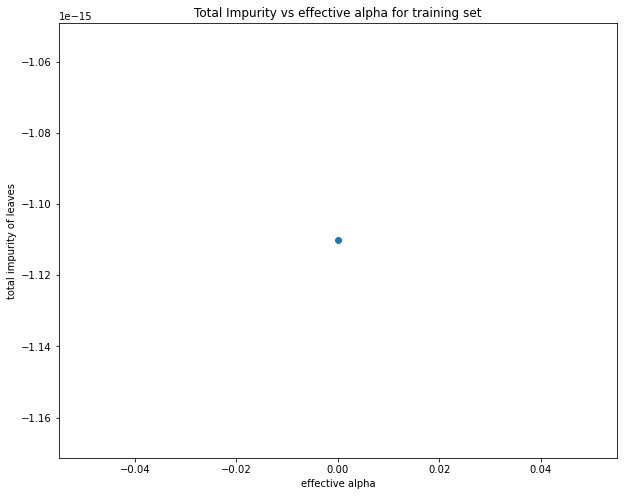

In [17]:
#creazione delle labels
y_train_2vsAll= [1 if x == 2 else 0 for x in y_train]
y_test_2vsAll = [1 if x == 2 else 0 for x in y_test]

clf = tree.DecisionTreeClassifier(random_state=seed, class_weight = 'balanced')
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_train_2vsAll)

#separo gli alpha dai valori delle impurità nelle foglie
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#desidero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
#rimuovo l'ultimo effective alpha perchè determina un pruning che porta ad avere un DT con un solo nodo
#non includo l'ultimo punto perchè è funzionalmente inutile
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [18]:
#ora alleno vari alberi usando gli effective alpha appena trovati, incluso l'ultimo, e stampo 
#l'ultimo effective alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha, class_weight = 'balanced')
    clf.fit(X_train, y_train_2vsAll)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.5000000000000007


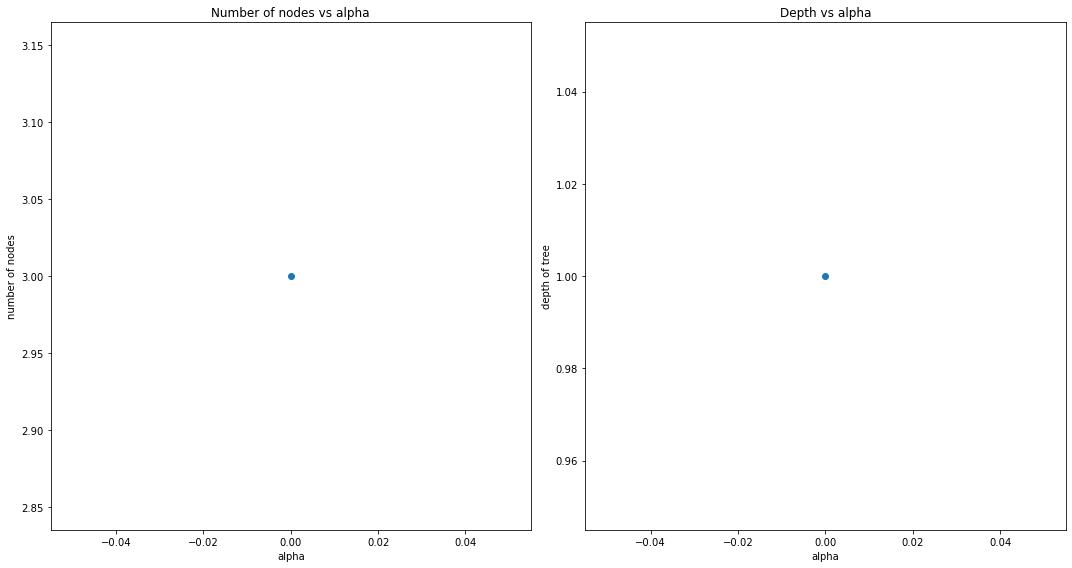

In [19]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 8)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

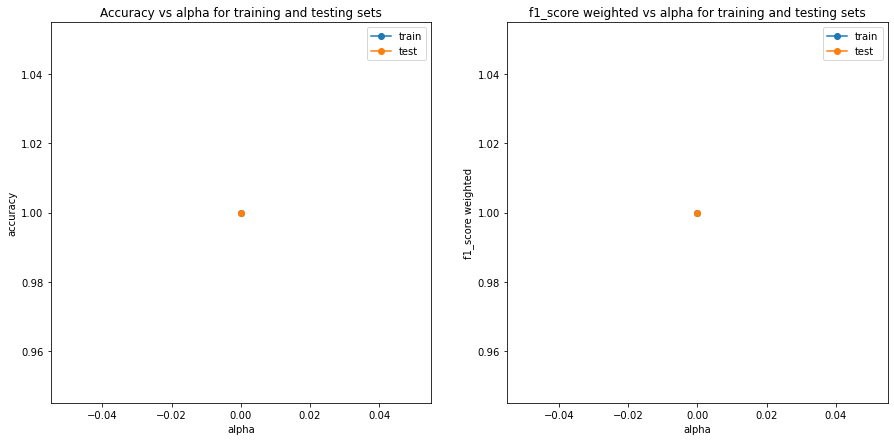

In [20]:
#ora studio come le performance variano al variare di alpha
#in questa cella uso mean accuracy e f1_score weighted
train_scores_acc = [clf.score(X_train, y_train_2vsAll) for clf in clfs]
test_scores_acc = [clf.score(X_test, y_test_2vsAll) for clf in clfs]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 7)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy vs alpha for training and testing sets")
ax[0].plot(ccp_alphas, train_scores_acc, marker='o', label="train",
        drawstyle="steps-post")
ax[0].plot(ccp_alphas, test_scores_acc, marker='o', label="test",
        drawstyle="steps-post")
ax[0].legend()

train_scores_f1 = [f1_score(y_train_2vsAll, clf.predict(X_train), average = 'weighted') for clf in clfs]
test_scores_f1 =[f1_score(y_test_2vsAll, clf.predict(X_test), average = 'weighted') for clf in clfs]
                 

ax[1].set_xlabel("alpha")
ax[1].set_ylabel("f1_score weighted")
ax[1].set_title("f1_score weighted vs alpha for training and testing sets")
ax[1].plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax[1].legend()

plt.show()



[Text(418.5, 611.55, 'ADC <= 0.6\ngini = 0.5\nsamples = 82\nvalue = [41.0, 41.0]\nclass = 0'),
 Text(209.25, 203.85000000000002, 'gini = 0.0\nsamples = 4\nvalue = [0, 41]\nclass = 1'),
 Text(627.75, 203.85000000000002, 'gini = -0.0\nsamples = 78\nvalue = [41.0, 0.0]\nclass = 0')]

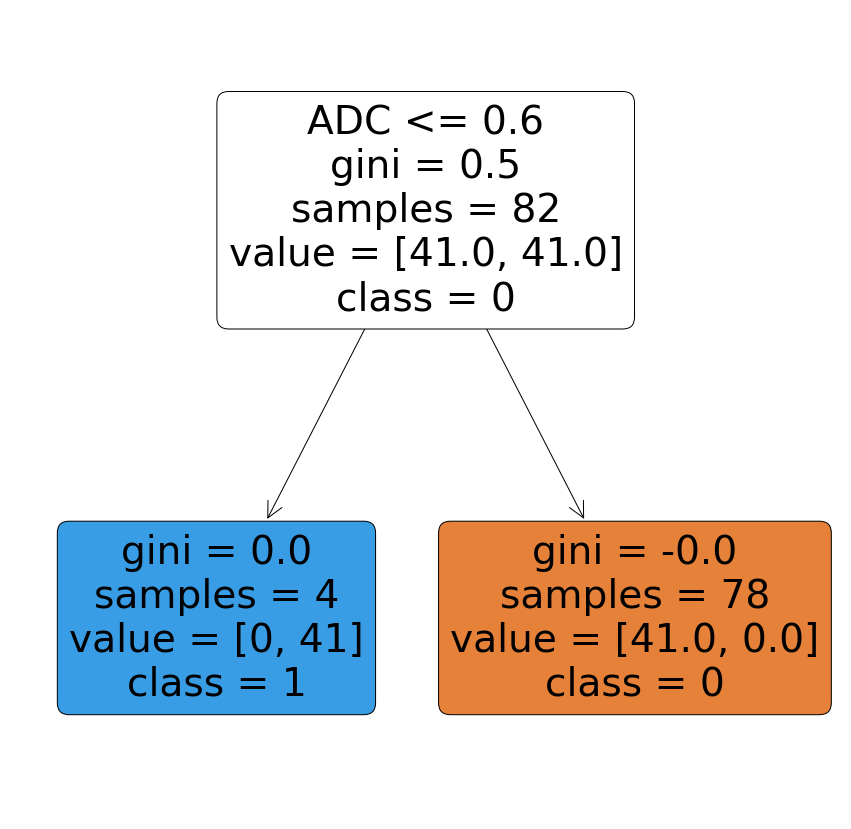

In [21]:
best_clf = clfs[0]
plt.figure(figsize=(15,15))
tree.plot_tree(best_clf,
               feature_names = X.columns,
               class_names = ['0', '1'], filled = True, rounded = True)

## 3 vs All


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

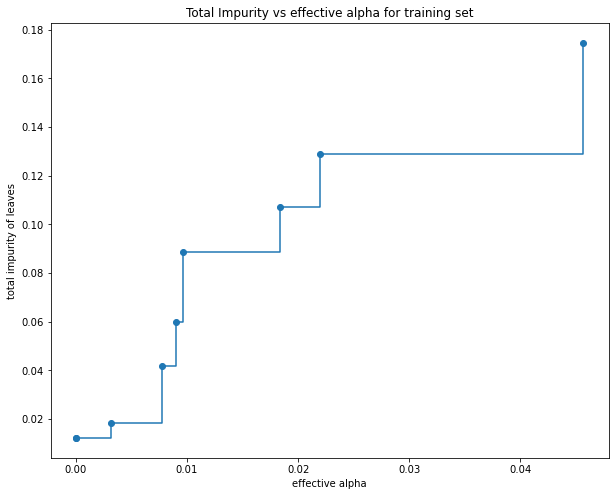

In [22]:
#complexity pruning per albero 3 vs all
### 3 vs All

#creazione delle labels
y_train_3vsAll = [1 if x == 3 else 0 for x in y_train]
y_test_3vsAll = [1 if x == 3 else 0 for x in y_test]

clf = tree.DecisionTreeClassifier(random_state=seed, class_weight = 'balanced')
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_train_3vsAll)

#separo gli alpha dai valori delle impurità nelle foglie
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#desidero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
#rimuovo l'ultimo effective alpha perchè determina un pruning che porta ad avere un DT con un solo nodo
#non includo l'ultimo punto perchè è funzionalmente inutile
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [23]:
#ora alleno vari alberi usando gli effective alpha appena trovati, incluso l'ultimo, e stampo 
#l'ultimo effective alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha, class_weight = 'balanced')
    clf.fit(X_train, y_train_3vsAll)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3253175289743395


Text(0.5, 1.0, 'Depth vs alpha')

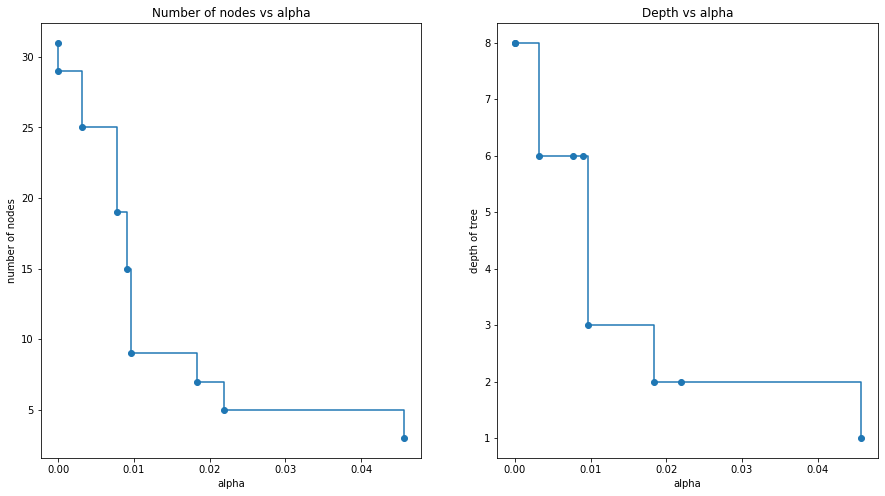

In [24]:
#ora rimuovo l'ultimo valore effective alpha perchè, come ho appena mostrato, conduce ad un albero costituito 
#da un solo nodo
#e mostro come il numero di nodi e la profondità variano al variare dei valori di alpha
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 8)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")


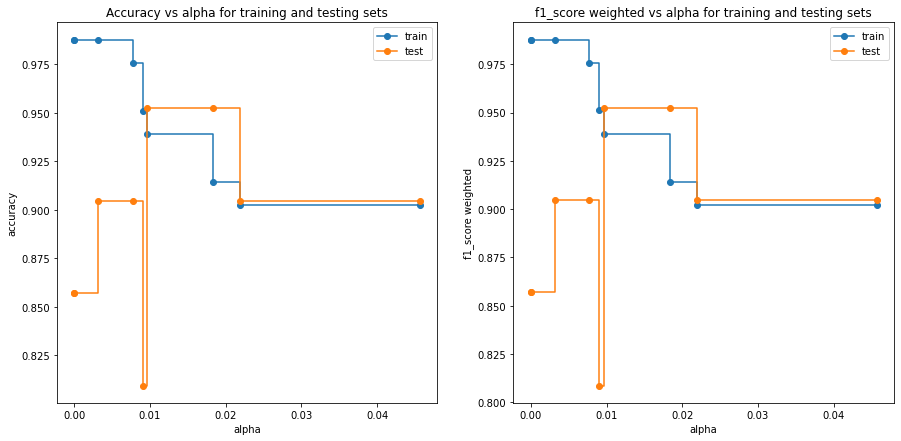

In [25]:
#ora studio come le performance variano al variare di alpha
#in questa cella uso mean accuracy
train_scores_acc = [clf.score(X_train, y_train_3vsAll) for clf in clfs]
test_scores_acc = [clf.score(X_test, y_test_3vsAll) for clf in clfs]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 7)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy vs alpha for training and testing sets")
ax[0].plot(ccp_alphas, train_scores_acc, marker='o', label="train",
        drawstyle="steps-post")
ax[0].plot(ccp_alphas, test_scores_acc, marker='o', label="test",
        drawstyle="steps-post")
ax[0].legend()

train_scores_f1 = [f1_score(y_train_3vsAll, clf.predict(X_train), average = 'weighted') for clf in clfs]
test_scores_f1 =[f1_score(y_test_3vsAll, clf.predict(X_test), average = 'weighted') for clf in clfs]
                 

ax[1].set_xlabel("alpha")
ax[1].set_ylabel("f1_score weighted")
ax[1].set_title("f1_score weighted vs alpha for training and testing sets")
ax[1].plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax[1].legend()


plt.show()

[Text(418.5, 713.475, 'ADC <= 1.075\ngini = 0.5\nsamples = 82\nvalue = [41.0, 41.0]\nclass = 0'),
 Text(209.25, 509.625, 'TIC type_A <= 0.5\ngini = 0.1\nsamples = 36\nvalue = [34.85, 1.952]\nclass = 0'),
 Text(104.625, 305.775, 'gini = 0.053\nsamples = 35\nvalue = [34.85, 0.976]\nclass = 0'),
 Text(313.875, 305.775, 'gini = -0.0\nsamples = 1\nvalue = [0.0, 0.976]\nclass = 1'),
 Text(627.75, 509.625, 'TIC type_A <= 0.5\ngini = 0.235\nsamples = 46\nvalue = [6.15, 39.048]\nclass = 1'),
 Text(523.125, 305.775, 'TIC type_B <= 0.5\ngini = 0.493\nsamples = 14\nvalue = [6.15, 7.81]\nclass = 1'),
 Text(418.5, 101.92499999999995, 'gini = 0.451\nsamples = 12\nvalue = [4.1, 7.81]\nclass = 1'),
 Text(627.75, 101.92499999999995, 'gini = 0.0\nsamples = 2\nvalue = [2.05, 0.0]\nclass = 0'),
 Text(732.375, 305.775, 'gini = -0.0\nsamples = 32\nvalue = [0.0, 31.238]\nclass = 1')]

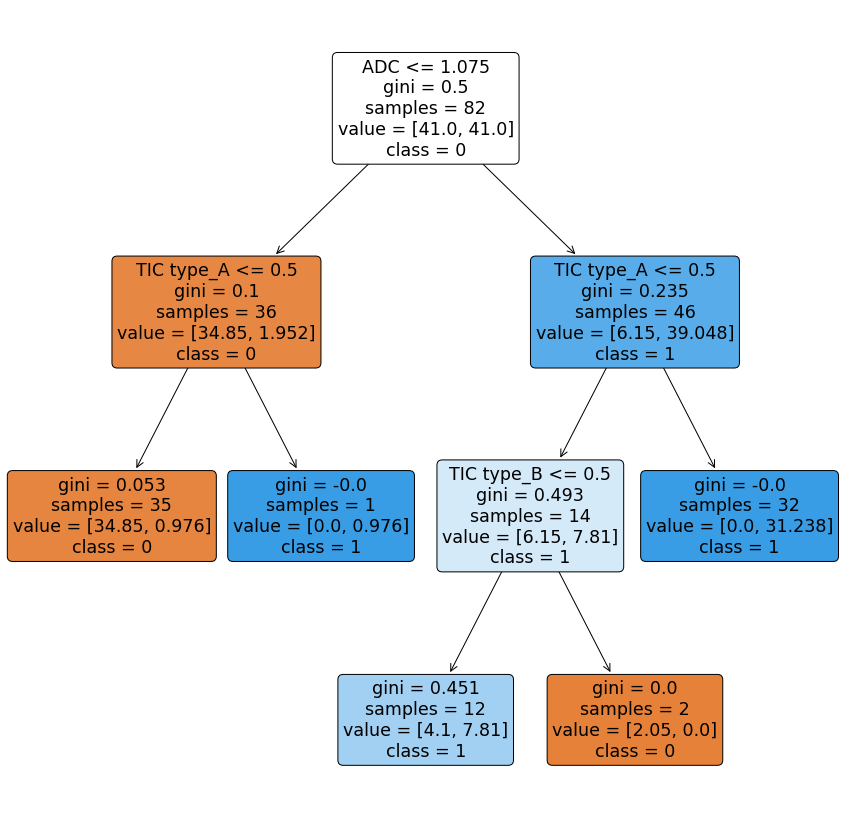

In [26]:
best_clf = clfs[5]
plt.figure(figsize=(15,15))
tree.plot_tree(best_clf,
               feature_names = X.columns,
               class_names = ['0', '1'], filled = True, rounded = True)

## 4 vs all

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

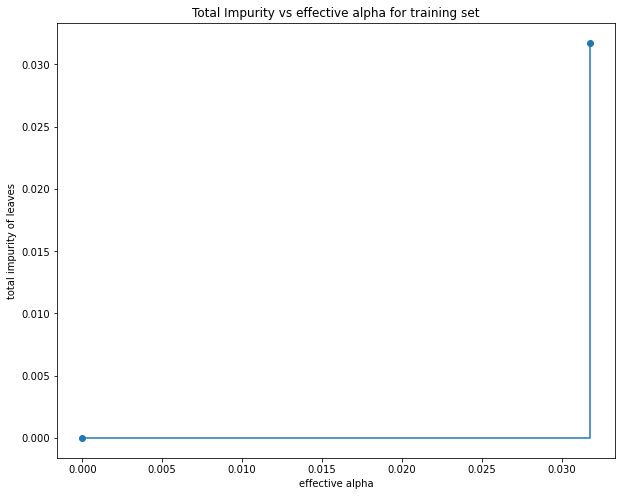

In [27]:
### 4 vs All

#creazione delle labels
y_train_4vsAll = [1 if x == 4 else 0 for x in y_train]
y_test_4vsAll = [1 if x == 4 else 0 for x in y_test]

clf = tree.DecisionTreeClassifier(random_state=seed, class_weight = 'balanced')
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_train_4vsAll)

#separo gli alpha dai valori delle impurità nelle foglie
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#desidero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
#rimuovo l'ultimo effective alpha perchè determina un pruning che porta ad avere un DT con un solo nodo
#non includo l'ultimo punto perchè è funzionalmente inutile
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [28]:
#ora alleno vari alberi usando gli effective alpha appena trovati, incluso l'ultimo, e stampo 
#l'ultimo effective alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha, class_weight = 'balanced')
    clf.fit(X_train, y_train_4vsAll)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.4682539682539697


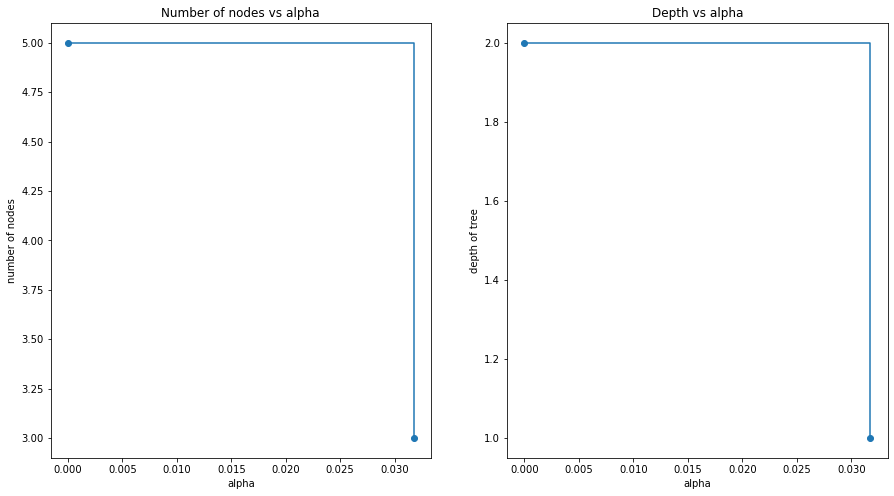

In [29]:
#ora rimuovo l'ultimo valore effective alpha perchè, come ho appena mostrato, conduce ad un albero costituito 
#da un solo nodo
#e mostro come il numero di nodi e la profondità variano al variare dei valori di alpha
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 8)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
plt.show()

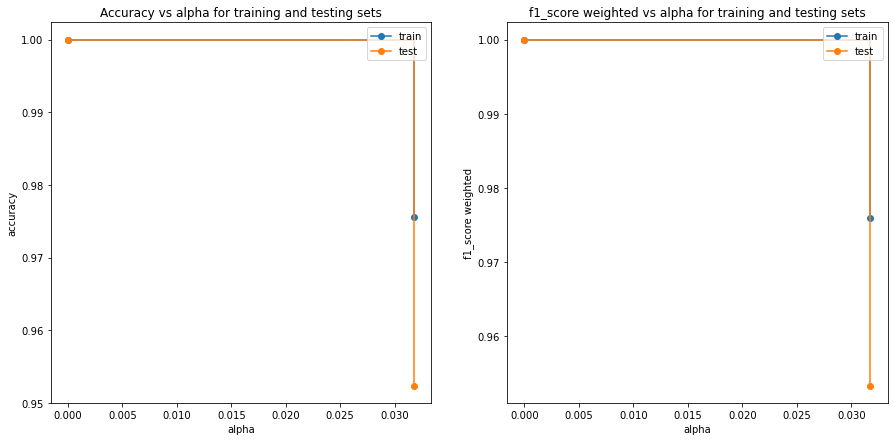

In [30]:
#ora studio come le performance variano al variare di alpha
#in questa cella uso mean accuracy
train_scores_acc = [clf.score(X_train, y_train_4vsAll) for clf in clfs]
test_scores_acc = [clf.score(X_test, y_test_4vsAll) for clf in clfs]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 7)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy vs alpha for training and testing sets")
ax[0].plot(ccp_alphas, train_scores_acc, marker='o', label="train",
        drawstyle="steps-post")
ax[0].plot(ccp_alphas, test_scores_acc, marker='o', label="test",
        drawstyle="steps-post")
ax[0].legend()

train_scores_f1 = [f1_score(y_train_4vsAll, clf.predict(X_train), average = 'weighted') for clf in clfs]
test_scores_f1 =[f1_score(y_test_4vsAll, clf.predict(X_test), average = 'weighted') for clf in clfs]
                 

ax[1].set_xlabel("alpha")
ax[1].set_ylabel("f1_score weighted")
ax[1].set_title("f1_score weighted vs alpha for training and testing sets")
ax[1].plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax[1].legend()


plt.show()

[Text(334.8, 679.5, 'TIC type_B <= 0.5\ngini = 0.5\nsamples = 82\nvalue = [41.0, 41.0]\nclass = 1'),
 Text(167.4, 407.69999999999993, 'gini = -0.0\nsamples = 59\nvalue = [39.656, 0.0]\nclass = 0'),
 Text(502.20000000000005, 407.69999999999993, 'ADC <= 0.6\ngini = 0.061\nsamples = 23\nvalue = [1.344, 41.0]\nclass = 1'),
 Text(334.8, 135.89999999999998, 'gini = 0.0\nsamples = 2\nvalue = [1.344, 0.0]\nclass = 0'),
 Text(669.6, 135.89999999999998, 'gini = -0.0\nsamples = 21\nvalue = [0.0, 41.0]\nclass = 1')]

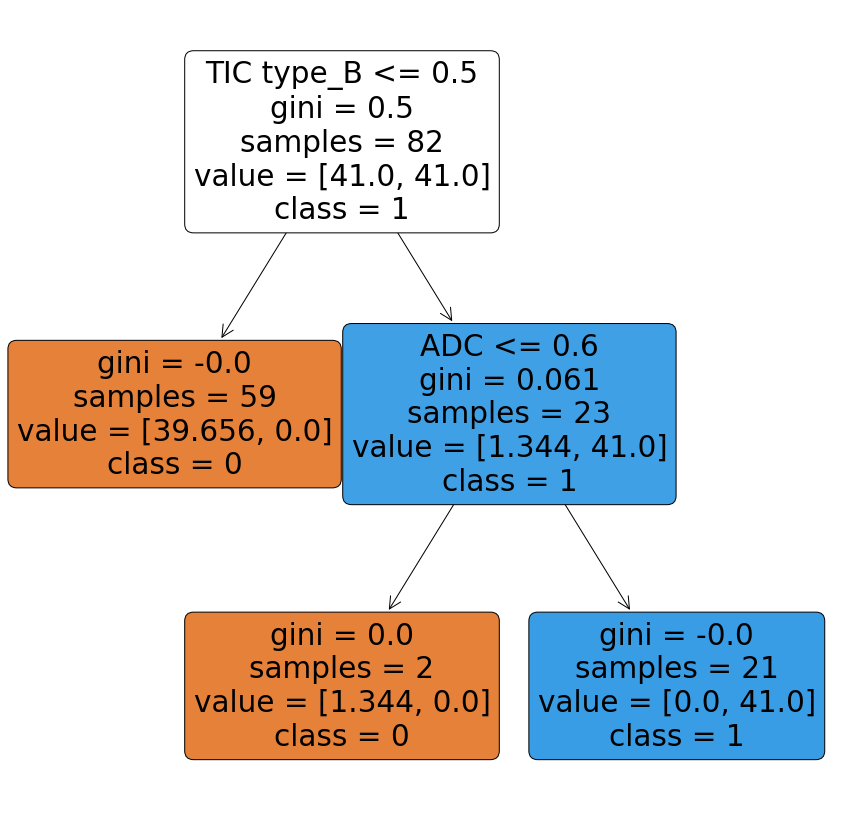

In [31]:
best_clf = clfs[0]
plt.figure(figsize=(15,15))
tree.plot_tree(best_clf,
               feature_names = X.columns,
               class_names = ['0', '1'], filled = True, rounded = True)

# 5 vs all

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

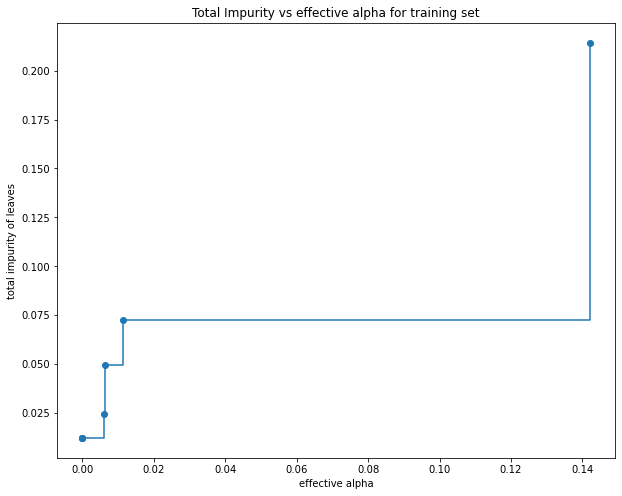

In [32]:
### 5 vs All

#creazione delle labels
y_train_5vsAll = [1 if x == 5 else 0 for x in y_train]
y_test_5vsAll = [1 if x == 5 else 0 for x in y_test]

clf = tree.DecisionTreeClassifier(random_state=seed, class_weight = 'balanced')
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_train_5vsAll)

#separo gli alpha dai valori delle impurità nelle foglie
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#desidero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
#rimuovo l'ultimo effective alpha perchè determina un pruning che porta ad avere un DT con un solo nodo
#non includo l'ultimo punto perchè è funzionalmente inutile
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [33]:
#ora alleno vari alberi usando gli effective alpha appena trovati, incluso l'ultimo, e stampo 
#l'ultimo effective alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha, class_weight = 'balanced')
    clf.fit(X_train, y_train_5vsAll)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.2857142857142843


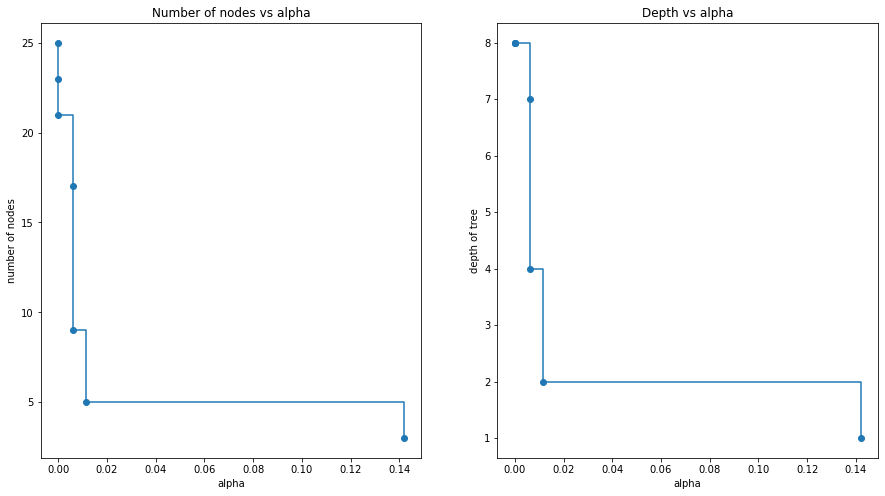

In [34]:
#ora rimuovo l'ultimo valore effective alpha perchè, come ho appena mostrato, conduce ad un albero costituito 
#da un solo nodo
#e mostro come il numero di nodi e la profondità variano al variare dei valori di alpha
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 8)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
plt.show()

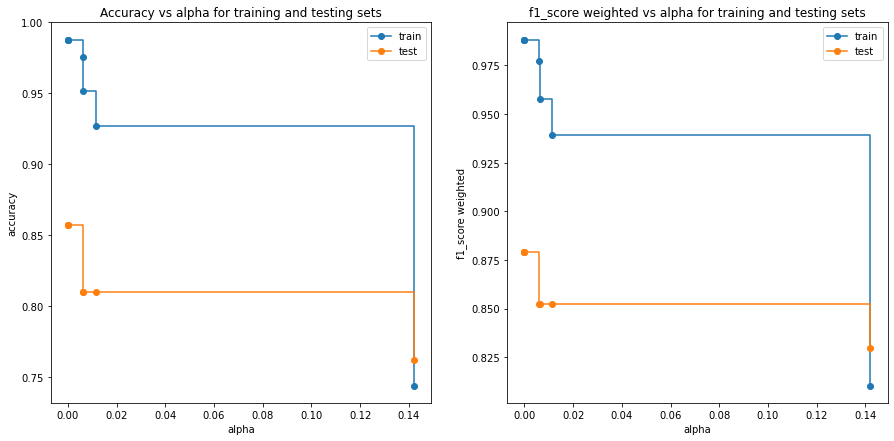

In [35]:
#ora studio come le performance variano al variare di alpha
#in questa cella uso mean accuracy
train_scores_acc = [clf.score(X_train, y_train_5vsAll) for clf in clfs]
test_scores_acc = [clf.score(X_test, y_test_5vsAll) for clf in clfs]

fig, ax = plt.subplots(1,2)
fig.set_size_inches(15, 7)
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy vs alpha for training and testing sets")
ax[0].plot(ccp_alphas, train_scores_acc, marker='o', label="train",
        drawstyle="steps-post")
ax[0].plot(ccp_alphas, test_scores_acc, marker='o', label="test",
        drawstyle="steps-post")
ax[0].legend()

train_scores_f1 = [f1_score(y_train_5vsAll, clf.predict(X_train), average = 'weighted') for clf in clfs]
test_scores_f1 =[f1_score(y_test_5vsAll, clf.predict(X_test), average = 'weighted') for clf in clfs]
                 

ax[1].set_xlabel("alpha")
ax[1].set_ylabel("f1_score weighted")
ax[1].set_title("f1_score weighted vs alpha for training and testing sets")
ax[1].plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax[1].plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax[1].legend()


plt.show()

[Text(342.40909090909093, 770.1, 'TIC type_C <= 0.5\ngini = 0.5\nsamples = 82\nvalue = [41.0, 41.0]\nclass = 0'),
 Text(152.1818181818182, 679.5, 'TIC type_A <= 0.5\ngini = 0.0\nsamples = 56\nvalue = [29.818, 0.0]\nclass = 0'),
 Text(76.0909090909091, 588.9, 'gini = 0.0\nsamples = 23\nvalue = [12.247, 0.0]\nclass = 0'),
 Text(228.27272727272728, 588.9, 'gini = 0.0\nsamples = 33\nvalue = [17.571, 0.0]\nclass = 0'),
 Text(532.6363636363636, 679.5, 'T2 <= 0.5\ngini = 0.337\nsamples = 26\nvalue = [11.182, 41.0]\nclass = 1'),
 Text(380.4545454545455, 588.9, 'ADC <= 0.6\ngini = 0.134\nsamples = 11\nvalue = [3.195, 41.0]\nclass = 1'),
 Text(304.3636363636364, 498.3, 'gini = 0.0\nsamples = 1\nvalue = [0.532, 0.0]\nclass = 0'),
 Text(456.54545454545456, 498.3, 'Segni macro malignità <= 0.5\ngini = 0.115\nsamples = 10\nvalue = [2.662, 41.0]\nclass = 1'),
 Text(380.4545454545455, 407.7, 'ADC <= 1.225\ngini = 0.094\nsamples = 9\nvalue = [2.13, 41.0]\nclass = 1'),
 Text(228.27272727272728, 317.1, '

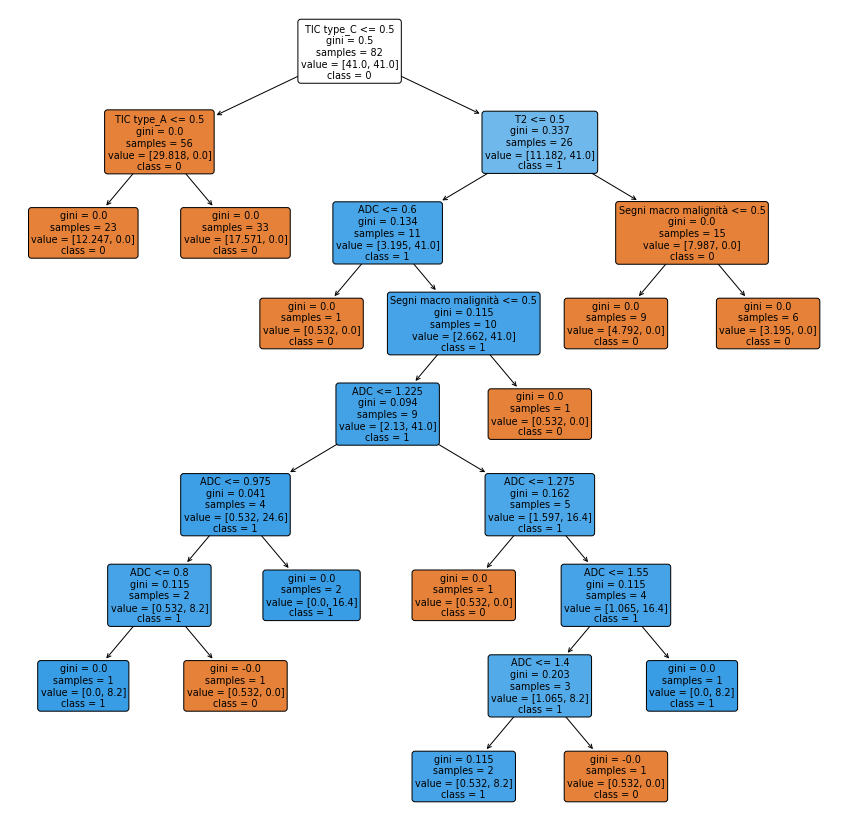

In [36]:
best_clf = clfs[0]
plt.figure(figsize=(15,15))
tree.plot_tree(best_clf,
               feature_names = X.columns,
               class_names = ['0', '1'], filled = True, rounded = True)